<a href="https://colab.research.google.com/github/mashyko/Image-Classifier/blob/master/transfer_learning_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG FineTuning for the dataset hymenoptera_data: Pytorch

 adapted from ©︎2019 『PyTorch ニューラルネットワーク実装ハンドブック』（秀和システム）第４章

modified and updated by mashyko

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
%matplotlib inline
import time
import os
import numpy as np
from matplotlib import pyplot as plt

In [0]:
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

True


In [0]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2020-04-16 05:12:28--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.84.90.18, 52.84.90.116, 52.84.90.114, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.84.90.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  36.5MB/s    in 1.2s    

2020-04-16 05:12:30 (36.5 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/trai

In [0]:
#画像の前処理を定義
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
#画像とラベルを読み込む
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=5,
                                             shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=5,
                                             shuffle=False, num_workers=4)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


In [0]:
for train in train_loader:
    print(train[0].shape)
    print(train[0].dtype)
    break

torch.Size([5, 3, 224, 224])
torch.float32


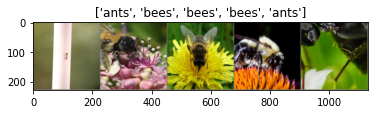

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
#ネットワークalexnetの定義
#net = models.alexnet(pretrained=True)
net = models.vgg16(pretrained=True)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
net

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
#ネットワークのパラメータを凍結
for param in net.parameters():
    param.requires_grad = False
net = net.to(device)
#最終層を2クラス用に変更
num_ftrs = net.classifier[6].in_features
net.classifier[6] = nn.Linear(num_ftrs, 2).to(device)
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
#最適化関数
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [0]:
num_epochs = 25

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val
    net.eval()
    with torch.no_grad():
      for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}, lr：{learning_rate}' 
                       .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc, learning_rate=optimizer.param_groups[0]["lr"]))
    #学習率調整
    lr_scheduler.step()
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/25], Loss: 0.2566, val_loss: 0.3601, val_acc: 0.8824, lr：0.01
Epoch [2/25], Loss: 0.4129, val_loss: 0.1870, val_acc: 0.9412, lr：0.01
Epoch [3/25], Loss: 0.1934, val_loss: 0.1670, val_acc: 0.9608, lr：0.01
Epoch [4/25], Loss: 0.2590, val_loss: 0.3136, val_acc: 0.9281, lr：0.01
Epoch [5/25], Loss: 0.3208, val_loss: 0.1101, val_acc: 0.9542, lr：0.01
Epoch [6/25], Loss: 0.1724, val_loss: 0.1071, val_acc: 0.9673, lr：0.01
Epoch [7/25], Loss: 0.1100, val_loss: 0.2369, val_acc: 0.9608, lr：0.01
Epoch [8/25], Loss: 0.2894, val_loss: 0.3074, val_acc: 0.9477, lr：0.01
Epoch [9/25], Loss: 0.1940, val_loss: 0.1186, val_acc: 0.9477, lr：0.01
Epoch [10/25], Loss: 0.3686, val_loss: 0.1768, val_acc: 0.9477, lr：0.01
Epoch [11/25], Loss: 0.2261, val_loss: 0.1706, val_acc: 0.9412, lr：0.001
Epoch [12/25], Loss: 0.1681, val_loss: 0.1549, val_acc: 0.9477, lr：0.001
Epoch [13/25], Loss: 0.2137, val_loss: 0.1528, val_acc: 0.9608, lr：0.001
Epoch [14/25], Loss: 0.0872, val_loss: 0.1588, val_acc: 0.9608, lr：0.0

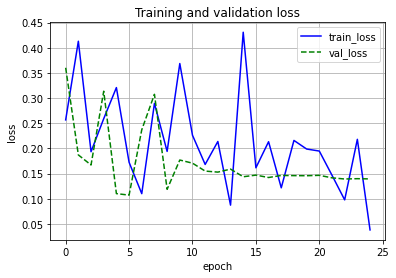

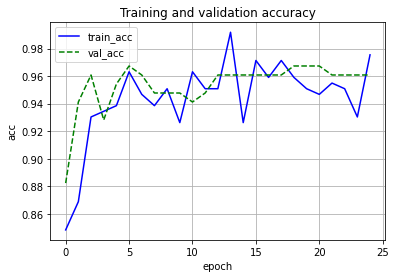

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

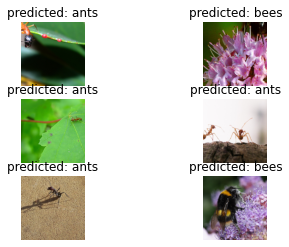

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
 
visualize_model(net)
